In [70]:
!pip install 'qiskit[all]'
!pip install plotly
!pip install gsgmorph

  Using cached matplotlib-3.4.3-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [71]:
!pip install matplotlib==3.1.3

  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.3
    Uninstalling matplotlib-3.4.3:
      Successfully uninstalled matplotlib-3.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-experiments 0.1.0 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [72]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from time import time
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import clear_output

In [73]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from dimod import BinaryQuadraticModel, AdjVectorBQM
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import LinearEqualityToPenalty, InequalityToEquality, IntegerToBinary
import neal

In [74]:
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit import Aer
from qiskit import QuantumCircuit
from qiskit.visualization import plot_state_city
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, ADAM, L_BFGS_B
from qiskit.optimization import QuadraticProgram
from docplex.mp.model import Model

from qiskit.optimization.applications.ising import stable_set
from qiskit import Aer
from qiskit.optimization.applications.ising import stable_set
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver, QAOA, NumPyEigensolver
from qiskit.aqua import aqua_globals
from qiskit.aqua import QuantumInstance
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.algorithms import MinimumEigenOptimizer


In [75]:
import gsgmorph.matrix_form as gsgm_mf
import networkx as nx

graph_to_embed = nx.Graph([(1,2),(2,3),(3,4),(1,4)])
target_graph = nx.Graph([('a','b'),('b','c'),('c', 'd'), ('a', 'd')])

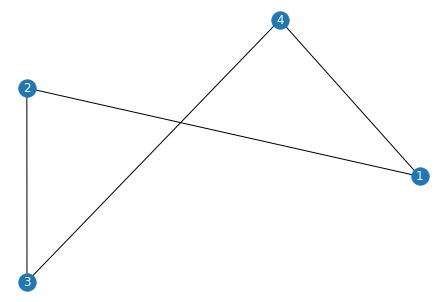

In [76]:
# Get fixed position
pos = nx.spring_layout(graph_to_embed, seed=9999)

# Graph to be embedded onto a target graph
nx.draw(graph_to_embed, pos, with_labels=True, font_color='w')

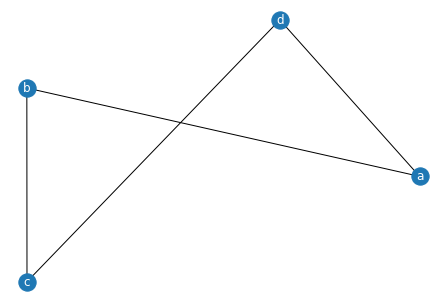

In [77]:
# Get fixed position
pos = nx.spring_layout(target_graph, seed=9999)

# Target graph, the above graph will be mapped to this one
nx.draw(target_graph, pos, with_labels=True, font_color='w')

In [78]:
# Obtain the QUBO and the sample translation dictionary
Q, sample_translation_dict = gsgm_mf.graph_isomorphism(graph_to_embed, target_graph)

In [79]:
def qubo_matrix_to_docplex(Q): 

  def build_matrix(data):
    data = dict(data)
    maxX = max([x for (x, y) in list(data.keys())])
    maxY = max([y for (x, y) in list(data.keys())])
    maxX = max([maxX, maxY])
    maxY = max([maxX, maxY])
    mat = np.zeros(shape=(maxX+1, maxY+1))
    for key, value in data.items():
        x, y = key
        mat[x][y] = value
    return mat

  # Print out the Qubo Matrix
  Q_matrix = build_matrix(Q)
  print(Q_matrix)
  print("Size of QUBO Matrix is: ", len(Q_matrix))

  def build_linear(Q, Q_matrix): 
    linear_dict = {}
    for idx in range(len(Q_matrix)): 
      linear_dict['x_{0}'.format(idx)] = Q[(idx,idx)]
    print('Linear part: ', linear_dict)
    return linear_dict

  def build_quadratic(Q, Q_matrix): 
    quadratic_dict = {}
    for node_pair in Q: 
      x,y = node_pair
      if x != y: 
        quadratic_dict[(f'x_{x}', f'x_{y}')] = Q[(x,y)]
    print('Quadratic Part: ', quadratic_dict)
    return quadratic_dict

  def build_constant(Q_matrix): 
    #Empirically decided!
    import math 
    number_of_nodes= math.sqrt(len(Q_matrix))
    constant = number_of_nodes * 2
    print(constant)
    return constant


  linear = build_linear(Q, Q_matrix)
  quadratic = build_quadratic(Q, Q_matrix)
  constant = build_constant(Q_matrix)

  mdl = QuadraticProgram('Graph Isomorphism')
  for node_pair in Q: 
    x,y = node_pair
    if x == y: 
      mdl.binary_var(name='x_{0}'.format(x))
  
  mdl.minimize(constant=constant, linear=linear, quadratic=quadratic)
  print(mdl.export_as_lp_string())

  return mdl

In [80]:
mdl = qubo_matrix_to_docplex(Q)

[[-2.  2.  2.  2.  3.  0.  1.  0.  2.  0.  0.  0.  3.  0.  1.  0.]
 [ 0. -2.  2.  2.  0.  3.  0.  1.  0.  2.  0.  0.  0.  3.  0.  1.]
 [ 0.  0. -2.  2.  1.  0.  3.  0.  0.  0.  2.  0.  1.  0.  3.  0.]
 [ 0.  0.  0. -2.  0.  1.  0.  3.  0.  0.  0.  2.  0.  1.  0.  3.]
 [ 0.  0.  0.  0. -2.  2.  2.  2.  3.  0.  1.  0.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -2.  2.  2.  0.  3.  0.  1.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -2.  2.  1.  0.  3.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  0.  1.  0.  3.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  2.  3.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  0.  3.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  1.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  0.  1.  0.  3.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2. 

In [81]:
aqua_globals.random_seed = 10598
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])
exact_mes = NumPyMinimumEigensolver()
vqe_mes = VQE(quantum_instance=quantum_instance)

In [82]:
qaoa = MinimumEigenOptimizer(qaoa_mes)   # using QAOA
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver
vqe = MinimumEigenOptimizer(vqe_mes)   # using VQE

In [83]:
exact_result = exact.solve(mdl)
print(exact_result)

optimal function value: 0.0
optimal value: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
status: SUCCESS


In [84]:
qaoa_result = qaoa.solve(mdl)
print(qaoa_result)

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning:

Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).



optimal function value: 0.0
optimal value: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
status: SUCCESS


In [85]:
vqe_result = vqe.solve(mdl)
print(vqe_result)

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning:

Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).



optimal function value: 3.0
optimal value: [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
status: SUCCESS


In [86]:
from qiskit.optimization.applications.ising import docplex

mdl_doc = docplex.Model()
mdl_doc = mdl.to_docplex()

In [87]:
mdl_doc

docplex.mp.Model['Graph Isomorphism']

In [88]:
from qiskit.optimization.applications.ising import docplex



qubitOp, offset = docplex.get_operator(mdl_doc)

In [89]:
offset

24.0

In [90]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()
print('get_operator')
print('tsp objective:', result['energy'] + offset)

get_operator
tsp objective: 0.0


/usr/local/lib/python3.7/dist-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:146: DeprecationWarning:

energy deprecated, use eigenvalue property.



In [91]:
print(qubitOp.print_details())

IIIIIIIIIIIIIIIZ	(-3+0j)
IIIIIIIIIIIIIIZI	(-3+0j)
IIIIIIIIIIIIIZII	(-3+0j)
IIIIIIIIIIIIZIII	(-3+0j)
IIIIIIIIIIIZIIII	(-3+0j)
IIIIIIIIIIZIIIII	(-3+0j)
IIIIIIIIIZIIIIII	(-3+0j)
IIIIIIIIZIIIIIII	(-3+0j)
IIIIIIIZIIIIIIII	(-3+0j)
IIIIIIZIIIIIIIII	(-3+0j)
IIIIIZIIIIIIIIII	(-3+0j)
IIIIZIIIIIIIIIII	(-3+0j)
IIIZIIIIIIIIIIII	(-3+0j)
IIZIIIIIIIIIIIII	(-3+0j)
IZIIIIIIIIIIIIII	(-3+0j)
ZIIIIIIIIIIIIIII	(-3+0j)
IIIIIIIIIIIIIIZZ	(0.5+0j)
IIIIIIIIIIIIIZIZ	(0.5+0j)
IIIIIIIIIIIIIZZI	(0.5+0j)
IIIIIIIIIIIIZIIZ	(0.5+0j)
IIIIIIIIIIIIZIZI	(0.5+0j)
IIIIIIIIIIIIZZII	(0.5+0j)
IIIIIIIIIIIZIIIZ	(0.75+0j)
IIIIIIIIIIIZIZII	(0.25+0j)
IIIIIIIIIIZIIIZI	(0.75+0j)
IIIIIIIIIIZIZIII	(0.25+0j)
IIIIIIIIIIZZIIII	(0.5+0j)
IIIIIIIIIZIIIIIZ	(0.25+0j)
IIIIIIIIIZIIIZII	(0.75+0j)
IIIIIIIIIZIZIIII	(0.5+0j)
IIIIIIIIIZZIIIII	(0.5+0j)
IIIIIIIIZIIIIIZI	(0.25+0j)
IIIIIIIIZIIIZIII	(0.75+0j)
IIIIIIIIZIIZIIII	(0.5+0j)
IIIIIIIIZIZIIIII	(0.5+0j)
IIIIIIIIZZIIIIII	(0.5+0j)
IIIIIIIZIIIIIIIZ	(0.5+0j)
IIIIIIIZIIIZIIII	(0.75+0j)
IIIIIIIZIZIIIIII	(0

In [92]:
# mapping Ising Hamiltonian to Quadratic Program
qp = QuadraticProgram()
qp.from_ising(qubitOp, offset)
qp.to_docplex().prettyprint()

// This file has been generated by DOcplex
// model name is: AnonymousModel
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;
dvar bool x_12;
dvar bool x_13;
dvar bool x_14;
dvar bool x_15;

minimize
 [ - 2 x_0^2 + 2 x_0*x_1 + 2 x_0*x_2 + 2 x_0*x_3 + 3 x_0*x_4 + x_0*x_6
 + 2 x_0*x_8 + 3 x_0*x_12 + x_0*x_14 - 2 x_1^2 + 2 x_1*x_2 + 2 x_1*x_3
 + 3 x_1*x_5 + x_1*x_7 + 2 x_1*x_9 + 3 x_1*x_13 + x_1*x_15 - 2 x_2^2
 + 2 x_2*x_3 + x_2*x_4 + 3 x_2*x_6 + 2 x_2*x_10 + x_2*x_12 + 3 x_2*x_14
 - 2 x_3^2 + x_3*x_5 + 3 x_3*x_7 + 2 x_3*x_11 + x_3*x_13 + 3 x_3*x_15
 - 2 x_4^2 + 2 x_4*x_5 + 2 x_4*x_6 + 2 x_4*x_7 + 3 x_4*x_8 + x_4*x_10
 + 2 x_4*x_12 - 2 x_5^2 + 2 x_5*x_6 + 2 x_5*x_7 + 3 x_5*x_9 + x_5*x_11
 + 2 x_5*x_13 - 2 x_6^2 + 2 x_6*x_7 + x_6*x_8 + 3 x_6*x_10 + 2 x_6*x_14
 - 2 x_7^2 + x_7*x_9 + 3 x_7*x_11 + 2 x_7*x_15 - 2 x_8^2 + 2 x_8*x_9
 + 2 x_8*x

In [93]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: 0.0
optimal value: [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
status: SUCCESS


In [94]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()

x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('total objective:', result.eigenvalue.real + offset)

energy: -24.0
total objective: 0.0


In [95]:
aqua_globals.random_seed = np.random.default_rng(123)
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [96]:
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, ADAM, L_BFGS_B, SPSA
from qiskit.circuit.library import TwoLocal

# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.run(quantum_instance)

# print results
x = sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning:

Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).



energy: -19.9404296875
time: 1652.6670050621033
max-cut objective: 4.0595703125


In [97]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

/usr/local/lib/python3.7/dist-packages/qiskit/utils/deprecation.py:62: DeprecationWarning:

Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).



optimal function value: 0.0
optimal value: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
status: SUCCESS
